<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/notebooks/covidradio_weighted_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/data_old.zip
#!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/QaTa.zip
 

!wget https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/util.py

Mounted at /content/drive
--2021-09-19 00:08:27--  https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5978 (5.8K) [text/plain]
Saving to: ‘util.py’

util.py             100%[===================>]   5.84K  --.-KB/s    in 0s      

2021-09-19 00:08:27 (43.2 MB/s) - ‘util.py’ saved [5978/5978]



In [2]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import pandas as pd

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.layers import GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.applications.densenet import DenseNet121, preprocess_input

import util

#### Get metadata on training set 

In [3]:
classes = ('normal', 'COVID')
data_path = 'data'

counts = []
filelists = []
for item in classes:
    filelist = os.listdir(os.path.join(data_path, 'train', item))
    filelists.append(filelist)
    counts.append(len(filelist))


#### Visualize samples of the image data by class

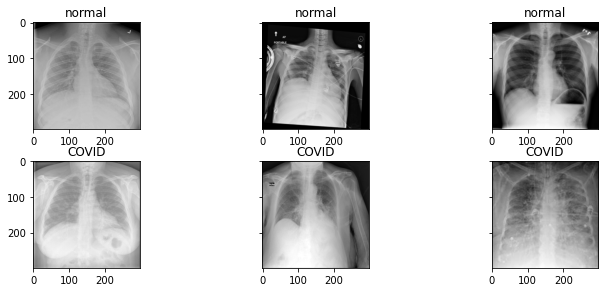

In [4]:
f, axes = plt.subplots(len(classes), 3, sharey=True)
f.set_figwidth(10)
plt.tight_layout()

for i, item in enumerate(classes):
    images = random.sample(filelists[i], 3)
    for j, image in enumerate(images):
        img_file = os.path.join(data_path, 'train', item, image)
        img = plt.imread(img_file)
        axes[i][j].imshow(img, cmap='gray')
        axes[i][j].set_title(item)


#### Plot prevalence of classes

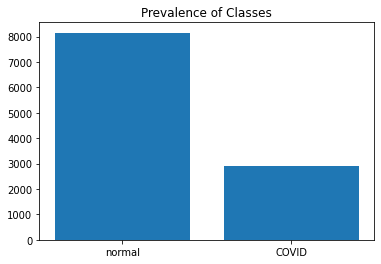

In [6]:
plt.bar(classes, counts)
plt.title('Prevalence of Classes');

#### Data generators to import images into the classifier

In [5]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_path = os.path.join(data_path, 'train')
train_gen = datagen.flow_from_directory(directory=train_path,
                    target_size=(224, 224),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

valid_path = os.path.join(data_path, 'validation')
valid_gen = datagen.flow_from_directory(directory=valid_path,
                    target_size=(224, 224),
                    batch_size=32,
                    shuffle=False,
                    class_mode='binary',
                    classes = classes)

test_path = os.path.join(data_path, 'test')
test_gen = datagen.flow_from_directory(directory=test_path,
                    target_size=(224, 224),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

Found 11045 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


In [ ]:

base_model = DenseNet121(weights='imagenet', 
                         input_shape=(224, 224, 3),
                         include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# freeze up to selected top conv block
for layer in model.layers:
    if layer.name == 'conv5_block1_1_conv':
        break
    layer.trainable = False

29097984/29084464 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

#### Compile and train

Epoch 1/25
346/346 [==============================] - 137s 287ms/step - loss: 0.0551 - accuracy: 0.9506 - val_loss: 0.0210 - val_accuracy: 0.9848
Epoch 2/25
346/346 [==============================] - 95s 273ms/step - loss: 0.0297 - accuracy: 0.9737 - val_loss: 0.0261 - val_accuracy: 0.9681
Epoch 3/25
346/346 [==============================] - 95s 274ms/step - loss: 0.0178 - accuracy: 0.9834 - val_loss: 0.0159 - val_accuracy: 0.9855
Epoch 4/25
346/346 [==============================] - 95s 276ms/step - loss: 0.0117 - accuracy: 0.9896 - val_loss: 0.0225 - val_accuracy: 0.9855
Epoch 5/25
346/346 [==============================] - 95s 275ms/step - loss: 0.0106 - accuracy: 0.9909 - val_loss: 0.0350 - val_accuracy: 0.9783
Epoch 6/25
346/346 [==============================] - 95s 275ms/step - loss: 0.0086 - accuracy: 0.9928 - val_loss: 0.0475 - val_accuracy: 0.9486
Epoch 7/25
346/346 [==============================] - 95s 275ms/step - loss: 0.0111 - accuracy: 0.9900 - val_loss: 0.0482 - val_a

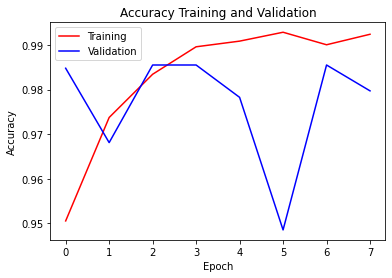

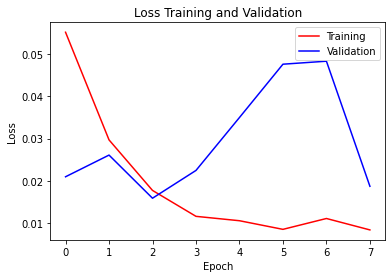

In [ ]:
model.compile(loss=util.Weighted_Loss(train_gen.classes), 
              optimizer='adam', 
              metrics=['accuracy'])

stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit(train_gen,
                    epochs=25,
                    steps_per_epoch=len(train_gen),
                    validation_data=valid_gen,
                    validation_steps=len(valid_gen),
                    verbose=1,
                    callbacks=[stop, reduce_lr])

model_path = os.path.join(BASE_PATH, 'densenet_model.h5')
model.save(model_path)

plt.plot(history.history['accuracy'], 'r', label='Training')
plt.plot(history.history['val_accuracy'], 'b', label="Validation")
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

plt.plot(history.history['loss'], 'r', label='Training')
plt.plot(history.history['val_loss'], 'b', label="Validation")
plt.title('Loss Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [8]:
model_path = os.path.join(BASE_PATH, 'densenet_model.h5')
model = load_model(model_path, compile=False)
model.compile(loss=util.Weighted_Loss(train_gen.classes), 
              optimizer='adam', 
              metrics=['accuracy'])

#### Evaluate the model

(Accuracy is not everything.)

In [ ]:
score = model.evaluate(valid_gen)
print(f'Accuracy Score = {round(score[1], 2) * 100}%')

44/44 [==============================] - 10s 214ms/step - loss: 0.0159 - accuracy: 0.9855
Accuracy Score = 99.0%


#### Calculate confusion matrix, precision, recall, f1

44/44 [==============================] - 11s 203ms/step


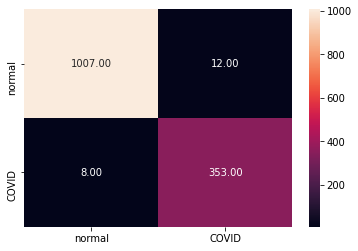

In [ ]:
y_true = np.array(valid_gen.classes)
y_true = np.expand_dims(y_true, axis=1)
y_raw_pred = model.predict(valid_gen, verbose=1)
y_pred = y_raw_pred > 0.5
y_pred = y_pred.astype(np.uint8)

cf = confusion_matrix(y_true, y_pred)
sns.heatmap(cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.2f');

#### Calculate Sensitivity, specificity, and PPV
Calculate PPV (Positive Predictive Value) using Bayes Theorem
 
 
$$ PPV = \frac{sensitivity \times prevalence}{sensitivity\times prevalence + (1 - specificty)\times(1 - prevalence)} $$

In [ ]:
labels = ['covid']
metrix_df, roc_curves = util.model_metrics(y_true, y_pred, labels)

metrix_df

,Accuracy,Sensitivity,Specificity,PPV,Auc_score
covid,0.985507,0.977839,0.988224,0.967123,0.983032


#### ROC-AUC curve and AUC score

No handles with labels found to put in legend.


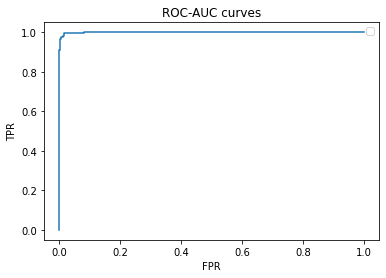

In [ ]:

fpr, tpr, _ = roc_curve(y_true, y_raw_pred)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f'ROC-AUC curves')
plt.legend()
plt.show()

### Separate distribution for testing model

Images from https://www.kaggle.com/aysendegerli/qatacov19-dataset

https://61fe395d74e2.ngrok.io/


In [ ]:
data_path2 = 'QaTa images'
test2_gen = datagen.flow_from_directory(directory=data_path2,
                    target_size=(224, 224),
                    batch_size=32,
                    shuffle=False,
                    class_mode='binary',
                    classes = classes)

Found 17147 images belonging to 2 classes.


In [ ]:
y_true2 = np.array(test2_gen.classes)
y_true2 = np.expand_dims(y_true2, axis=1)
y_pred2 = model.predict(test2_gen, verbose=1)
y_pred2 = y_pred2 > 0.5
y_pred2 = y_pred2.astype(np.uint8)

metrics2_df, _ = util.model_metrics(y_true2, y_pred2, labels)

536/536 [==============================] - 110s 206ms/step


In [ ]:
metrics2_df

,Accuracy,Sensitivity,Specificity,PPV,Auc_score
covid,0.959235,0.989138,0.948262,0.87524,0.9687


In [6]:
counts = []
filelists = []
for item in classes:
    filelist = os.listdir(os.path.join(data_path, 'test', item))
    filelists.append(filelist)
    counts.append(len(filelist))

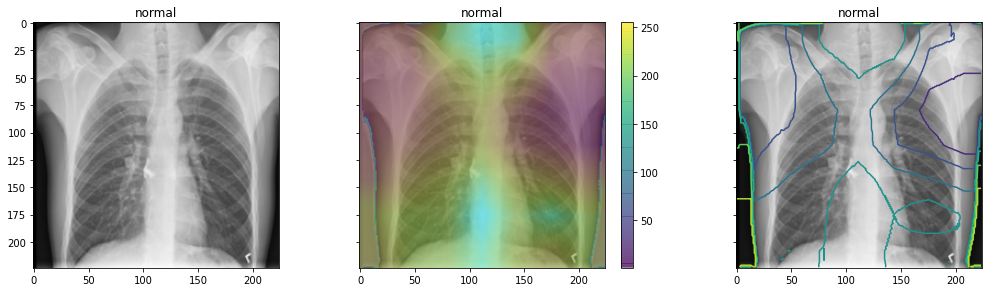

Actual class: normal
Predicted class: normal
Confidence: 80.55%


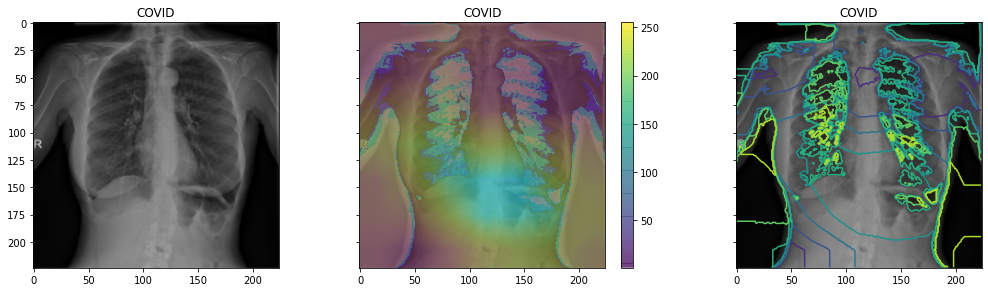

Actual class: COVID
Predicted class: COVID
Confidence: 99.36%


In [20]:
for i, item in enumerate(classes):

    f, axes = plt.subplots(1, 3, sharey=True)
    f.set_figwidth(15)
    plt.tight_layout()

    image_file = random.choice(filelists[i])
    image_path = os.path.join(data_path, 'test', item, image_file)
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    #pred_image = np.expand_dims(image, axis=0)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    pred_image = np.expand_dims(img, axis=0)
    pred_image = preprocess_input(pred_image)
    pred = model.predict(pred_image)
    prediction = int(pred[0][0] >= 0.5)

    if prediction:
      confidence = round(pred[0][0] * 100, 2)
    else:
      confidence = round((1 - pred[0][0]) * 100, 2)

    
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title(item)

    cam = util.grad_cam(model, pred_image, 0, 'conv5_block16_2_conv')

    axes[1].imshow(img, cmap='gray')
    pos = axes[1].imshow(cam, alpha=0.5)
    f.colorbar(pos, ax=axes[1])
    axes[1].set_title(item)

    cam_gs = cv2.cvtColor(cam, cv2.COLOR_RGB2GRAY)
    axes[2].imshow(img)
    axes[2].contour(cam_gs)
    axes[2].set_title(item)
    plt.show()

    print(f'Actual class: {item}')
    print(f'Predicted class: {classes[prediction]}')
    print(f'Confidence: {confidence}%')

    